1.

In [3]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [5]:
data = np.loadtxt('incomes.txt')
max_i = data.max()
min_i = data.min()

a)

<IPython.core.display.Javascript object>


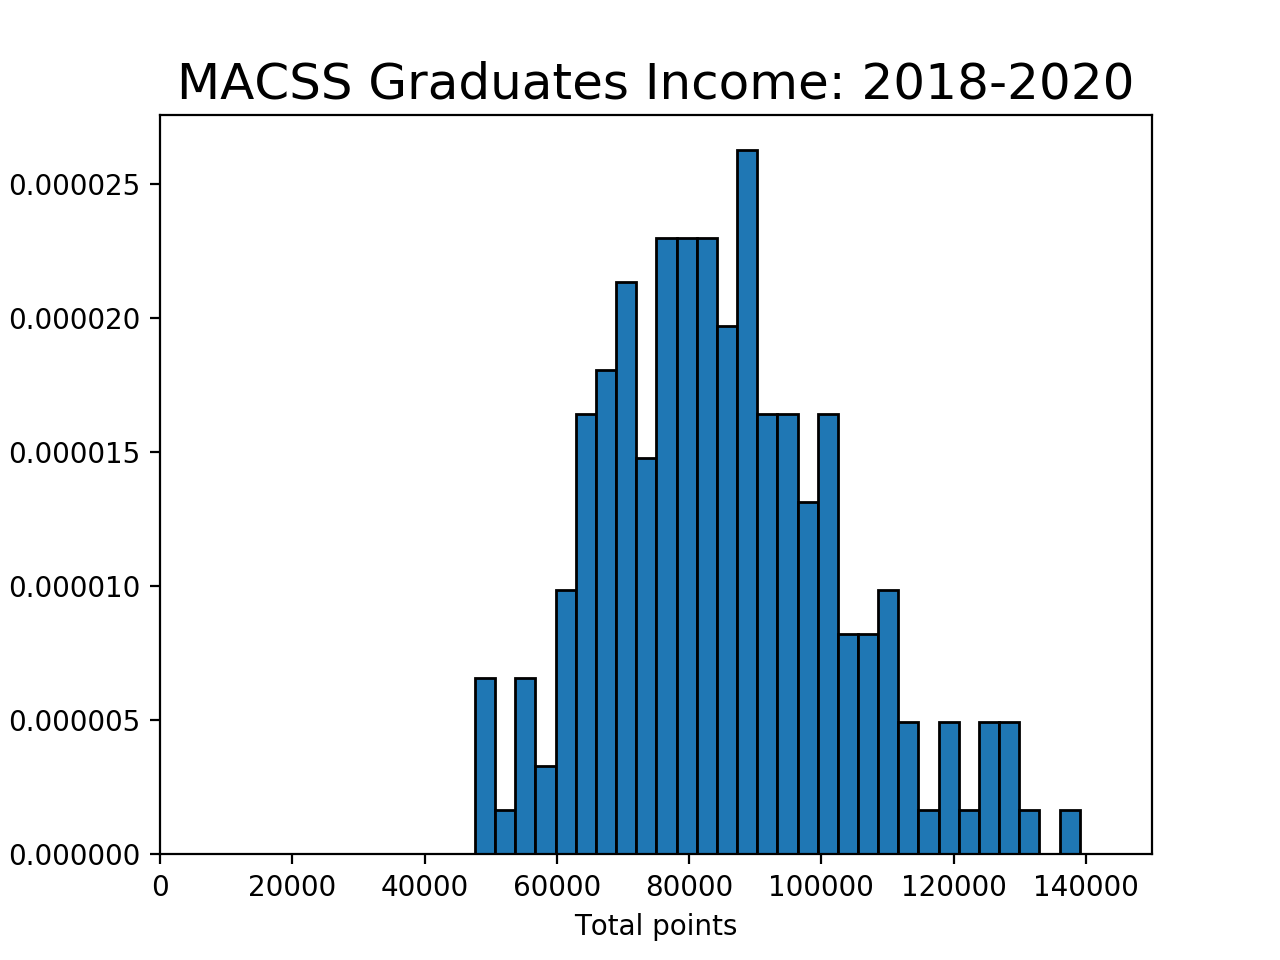

(0, 150000)

In [6]:
%matplotlib notebook

num_bins = 30
count, bins, ignored = plt.hist(data, num_bins,
                                edgecolor='k', density=True)
plt.title('MACSS Graduates Income: 2018-2020', fontsize=18)
plt.xlabel(r'Total points')
plt.ylabel(r'Percent of income')
plt.xlim([0, 150000]) 

b)

In [7]:
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    if cut_ub == None and cut_lb == None:
        prob_notcut = 1.0
    elif cut_ub == None and cut_lb != None:
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, loc=0, scale=mu)
    elif cut_ub != None and cut_lb == None:
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma, loc=0, scale=mu)
    elif cut_ub != None and cut_lb != None:
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma, loc=0, scale=mu) -
                       sts.lognorm.cdf(cut_lb, sigma, loc=0, scale=mu))
        #print(prob_notcut)
            
    pdf_vals    = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.absolute(np.log(xvals) - mu))**2 / (2 * sigma**2))) 
                   / prob_notcut)
    return pdf_vals  

In [11]:
def data_moments(xvals):
    mean_data = xvals.mean()
    var_data = xvals.var()
    
    return mean_data, var_data

def model_moments(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, var_model

def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val



Using $\hat{\mathbf{W}} = \mathbf{I}$

In [24]:
mu_pts, sig_pts = (np.log(data.mean()) - np.log((data.std() / data.mean()) ** 2 + 1)), np.sqrt(np.log((data.std() / data.mean()) ** 2 + 1))
print(mu_pts, sig_pts)

11.310103695493913 0.20869666161385902


In [26]:
params_init = np.array([10, 0.1])
W_hat = np.eye(len(params_init))
gmm_args = (data, 0.0, 150000.0, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args))
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
results

mu_GMM1= 11.336910397095968  sig_GMM1= 0.2130270629602816


      fun: array([[4.01372637e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.59313419e-09, -4.86060628e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 75
      nit: 13
   status: 0
  success: True
        x: array([11.3369104 ,  0.21302706])

In [27]:
mean_data, var_data = data_moments(data)
mean_model, var_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 150000.0)
err1 = err_vec(data, mu_GMM1, sig_GMM1, 0.0, 150000.0, False).reshape(len(params_init),)
print('Mean of points =', mean_data, ', Variance of points =', var_data)
print('Mean of model =', mean_model, ', Variance of model =', var_model)
print('Error vector=', err1)
results

Mean of points = 85276.82360625811 , Variance of points = 323731572.2295289
Mean of model = 85276.82766978943 , Variance of model = 323731558.71358055
Error vector= [ 4.76510633e-08 -4.17504795e-08]


      fun: array([[4.01372637e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.59313419e-09, -4.86060628e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 75
      nit: 13
   status: 0
  success: True
        x: array([11.3369104 ,  0.21302706])

<IPython.core.display.Javascript object>


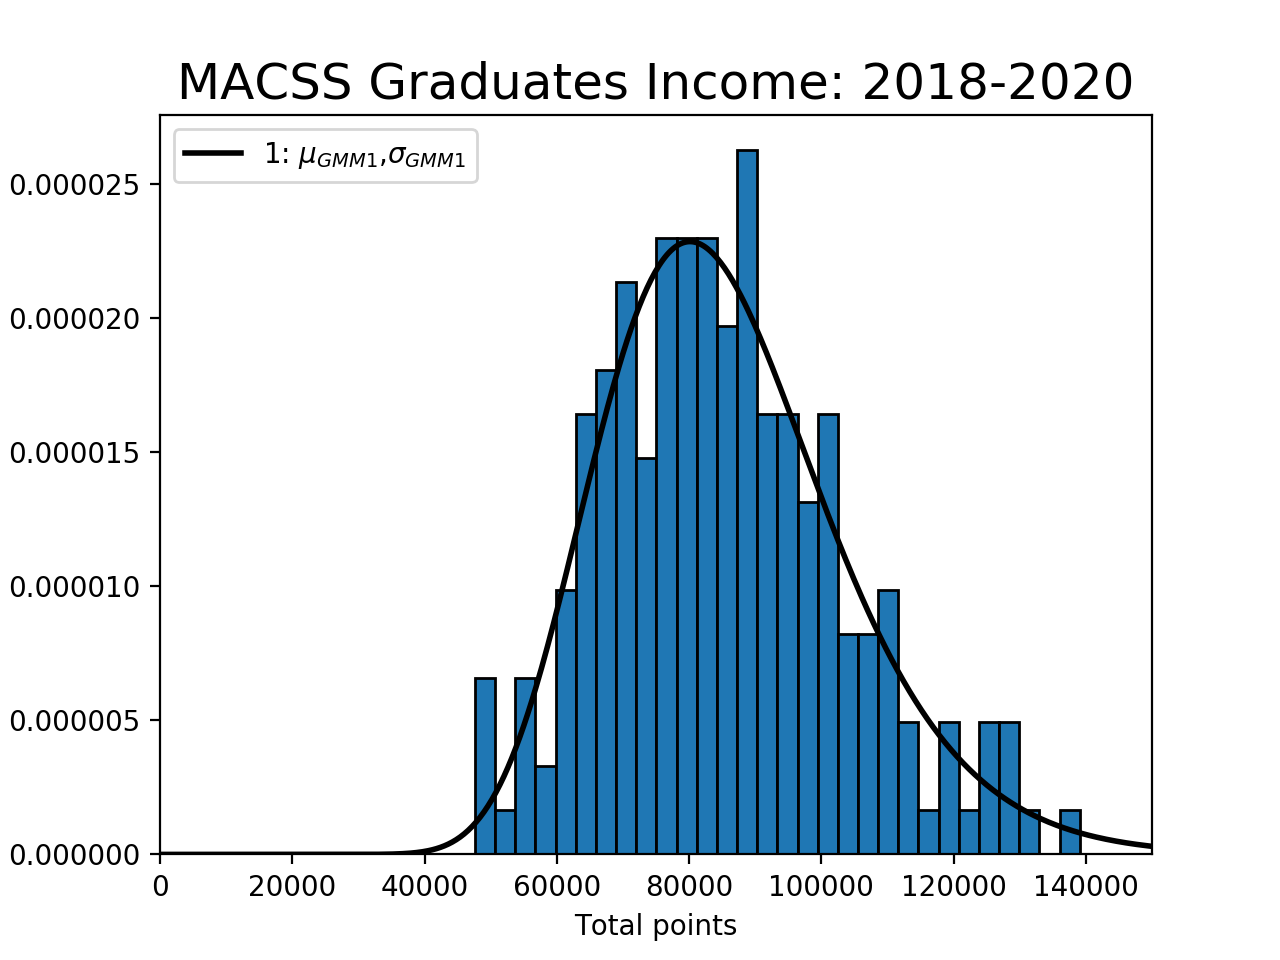

c:\users\pahadrianus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
c:\users\pahadrianus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
c:\users\pahadrianus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


In [29]:
num_bins = 30
count, bins, ignored = plt.hist(data, num_bins,
                                edgecolor='k', density=True)
plt.title('MACSS Graduates Income: 2018-2020', fontsize=18)
plt.xlabel(r'Total points')
plt.ylabel(r'Percent of income')
plt.xlim([0, 150000]) 

dist_pts = np.linspace(0, 150000, 500)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 450),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

c)

In [30]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - var_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - var_model) / var_model
    
    return Err_mat

In [32]:
Err_mat = get_Err_mat2(data, mu_GMM1, sig_GMM1, 0.0, 150000.0, False)
VCV2 = (1 / data.shape[0]) * (Err_mat @ Err_mat.T)
print(VCV2)
W_hat2 = lin.inv(VCV2)
print(W_hat2)

[[0.0445167  0.09358616]
 [0.09358616 1.94756678]]
[[24.98774398 -1.20073265]
 [-1.20073265  0.57115986]]


In [70]:
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (data, 0.0, 150000.0, W_hat2)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)
results

mu_GMM2= 11.336910397095968  sig_GMM2= 0.2130270629602816


      fun: array([[6.25109637e-14]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.24507314e-06, -1.00013559e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([11.3369104 ,  0.21302706])

<IPython.core.display.Javascript object>


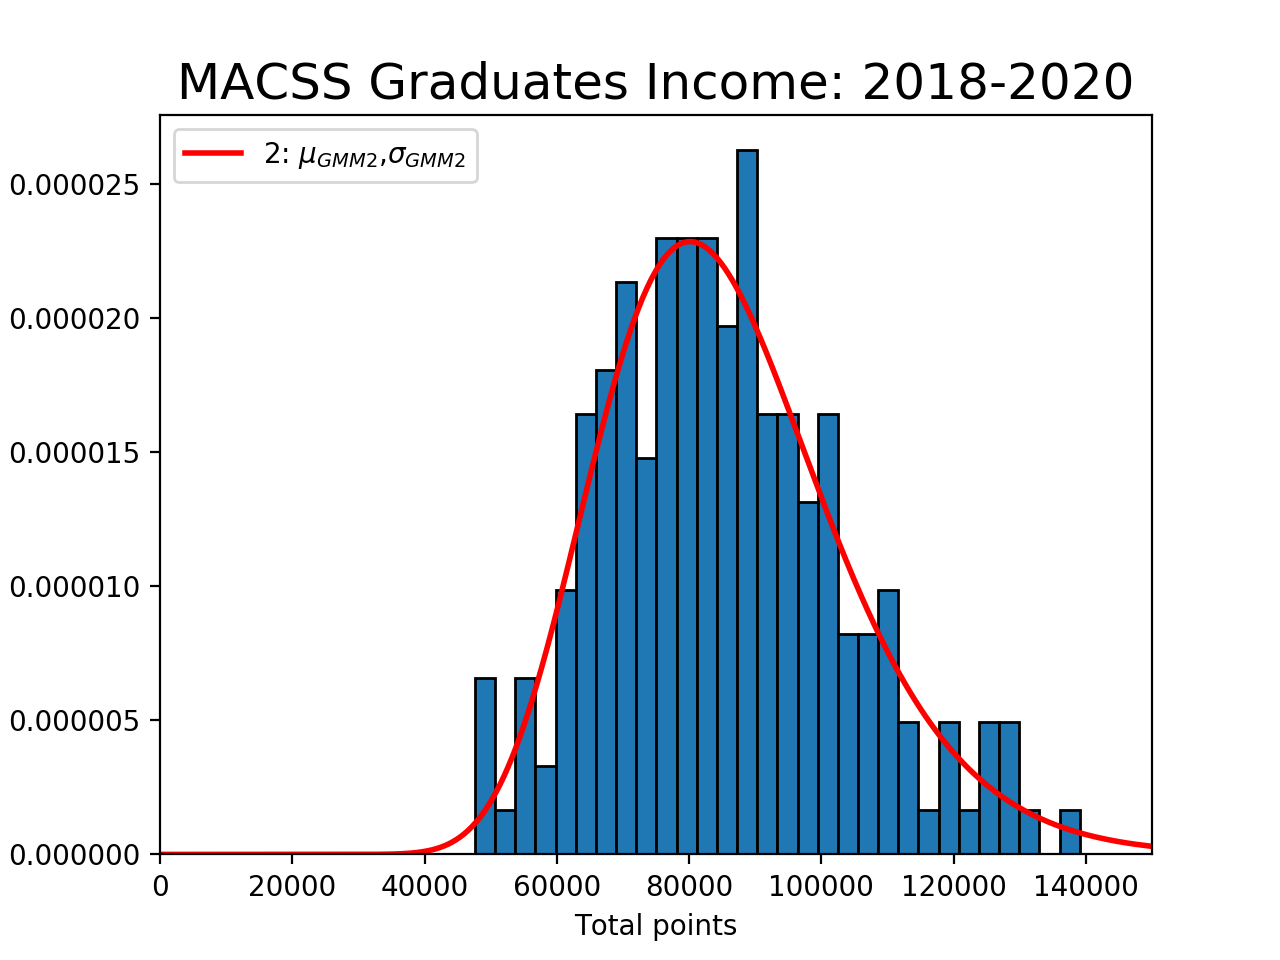

c:\users\pahadrianus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
c:\users\pahadrianus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
c:\users\pahadrianus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


In [59]:
num_bins = 30
count, bins, ignored = plt.hist(data, num_bins,
                                edgecolor='k', density=True)
plt.title('MACSS Graduates Income: 2018-2020', fontsize=18)
plt.xlabel(r'Total points')
plt.ylabel(r'Percent of income')
plt.xlim([0, 150000]) 

dist_pts = np.linspace(0, 150000, 500)

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, 0.0, 150000),
         linewidth=2, color='r', label='2: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')

d)

In [40]:
def data_moments3(xvals):

    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >= 75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = (xvals[xvals >= 100000].shape[0] /
                  xvals.shape[0])

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments3(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion3(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [41]:
params = np.array([mu_GMM1, sig_GMM1])
print('params=', params)
print(data_moments3(data))
print(model_moments3(mu_GMM1, sig_GMM1, 0.0, 150000))
print(criterion3(params, data, 0.0, 150000.0, np.eye(3)))

params= [11.3369104   0.21302706]
(0.3, 0.5, 0.2)
(0.30007262897660947, 0.49559816551428787, 0.20115871274794245)
[[0.00011113]]


In [54]:
params_init = np.array([10, 0.5])
W_hat1_3 = np.eye(3)
gmm_args = (data, 0.0, 150000.0, W_hat1_3)
results_3 = opt.minimize(criterion3, params_init, args=(gmm_args), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)
results_3

mu_GMM1_3= 11.336726449189163  sig_GMM1_3= 0.21174638441239005


      fun: array([[2.38181765e-05]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.93526586e-05, -8.91104343e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 135
      nit: 20
   status: 0
  success: True
        x: array([11.33672645,  0.21174638])

In [56]:
params = np.array([mu_GMM1_3, sig_GMM1_3])
print('params=', params)
print(data_moments3(data))
print(model_moments3(mu_GMM1, sig_GMM1, 0.0, 150000))
print(criterion3(params, data, 0.0, 150000.0, np.eye(3)))

params= [11.33672645  0.21174638]
(0.3, 0.5, 0.2)
(0.30007262897660947, 0.49559816551428787, 0.20115871274794245)
[[2.38181765e-05]]


<IPython.core.display.Javascript object>


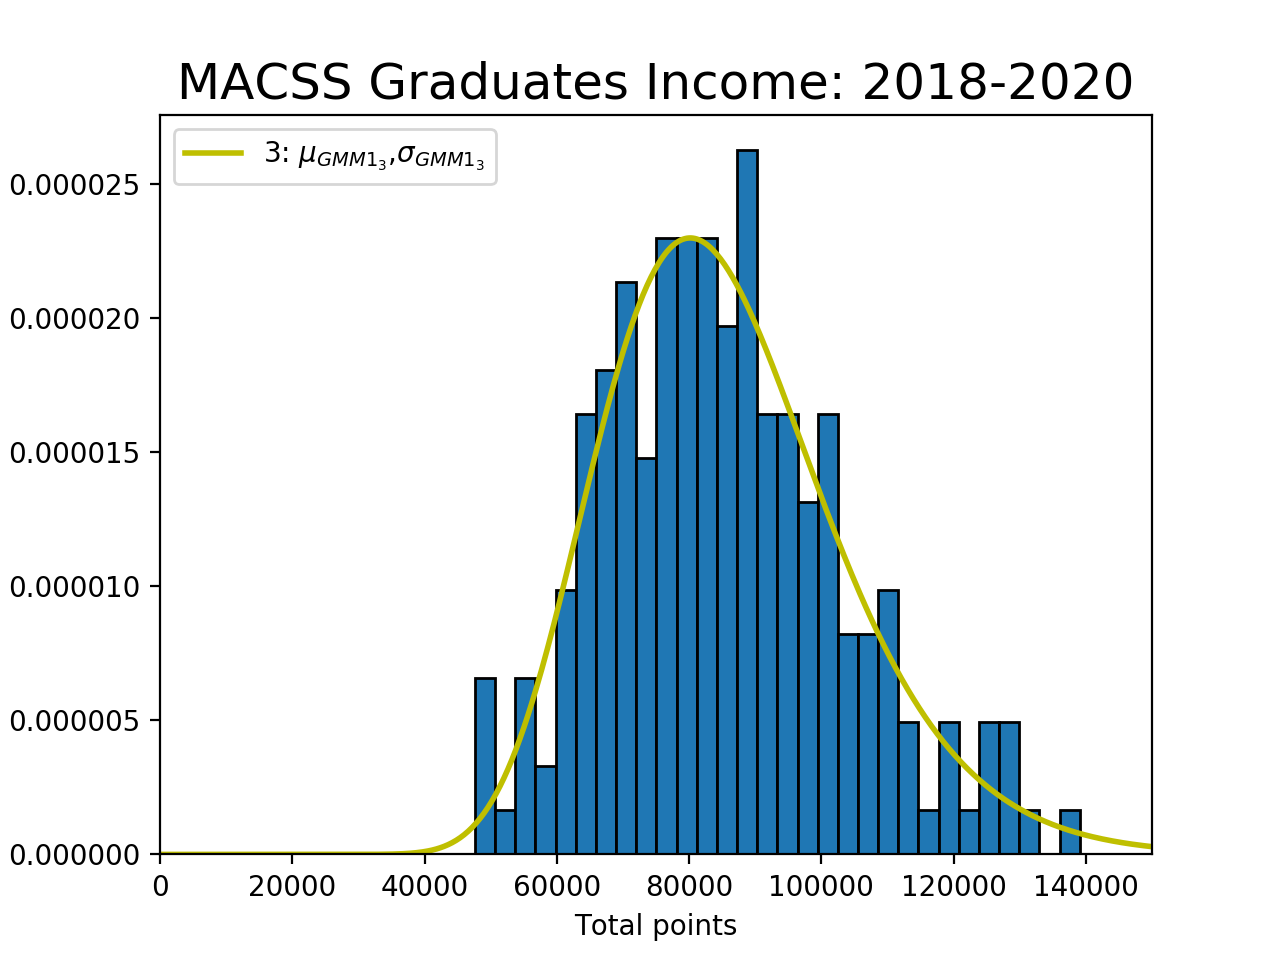

c:\users\pahadrianus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
c:\users\pahadrianus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
c:\users\pahadrianus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


In [61]:
num_bins = 30
count, bins, ignored = plt.hist(data, num_bins,
                                edgecolor='k', density=True)
plt.title('MACSS Graduates Income: 2018-2020', fontsize=18)
plt.xlabel(r'Total points')
plt.ylabel(r'Percent of income')
plt.xlim([0, 150000]) 

dist_pts = np.linspace(0, 150000, 500)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, 0.0, 1500000),
         linewidth=2, color='y', label='3: $\mu_{GMM1_3}$,$\sigma_{GMM1_3}$')
plt.legend(loc='upper left')

e)

In [66]:
def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod
    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [67]:
Err_mat3 = get_Err_mat3(data, mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, True)
VCV2_3 = (1 / data.shape[0]) * (Err_mat3 @ Err_mat3.T)
print(VCV2_3)
W_hat2_3 = lin.pinv(VCV2_3)
print(W_hat2_3)

[[ 0.21000053 -0.14999859 -0.05999975]
 [-0.14999859  0.25000377 -0.09999934]
 [-0.05999975 -0.09999934  0.16000011]]
[[110575.51632262 110571.69720698 110572.42794165]
 [110571.69720698 110573.21142468 110571.94215935]
 [110572.42794165 110571.94215935 110577.67289402]]


In [69]:
params_init = np.array([mu_GMM1_3, sig_GMM1_3])
gmm_args = (data, 0.0, 150000.0, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                          method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2_3, sig_GMM2_3 = results2_3.x
print('mu_GMM2_3=', mu_GMM2_3, ' sig_GMM2_3=', sig_GMM2_3)
results2_3

mu_GMM2_3= 11.336512012520181  sig_GMM2_3= 0.2139202439957802


      fun: array([[0.00068264]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.02025101, 0.04987821])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 84
      nit: 16
   status: 0
  success: True
        x: array([11.33651201,  0.21392024])

<IPython.core.display.Javascript object>


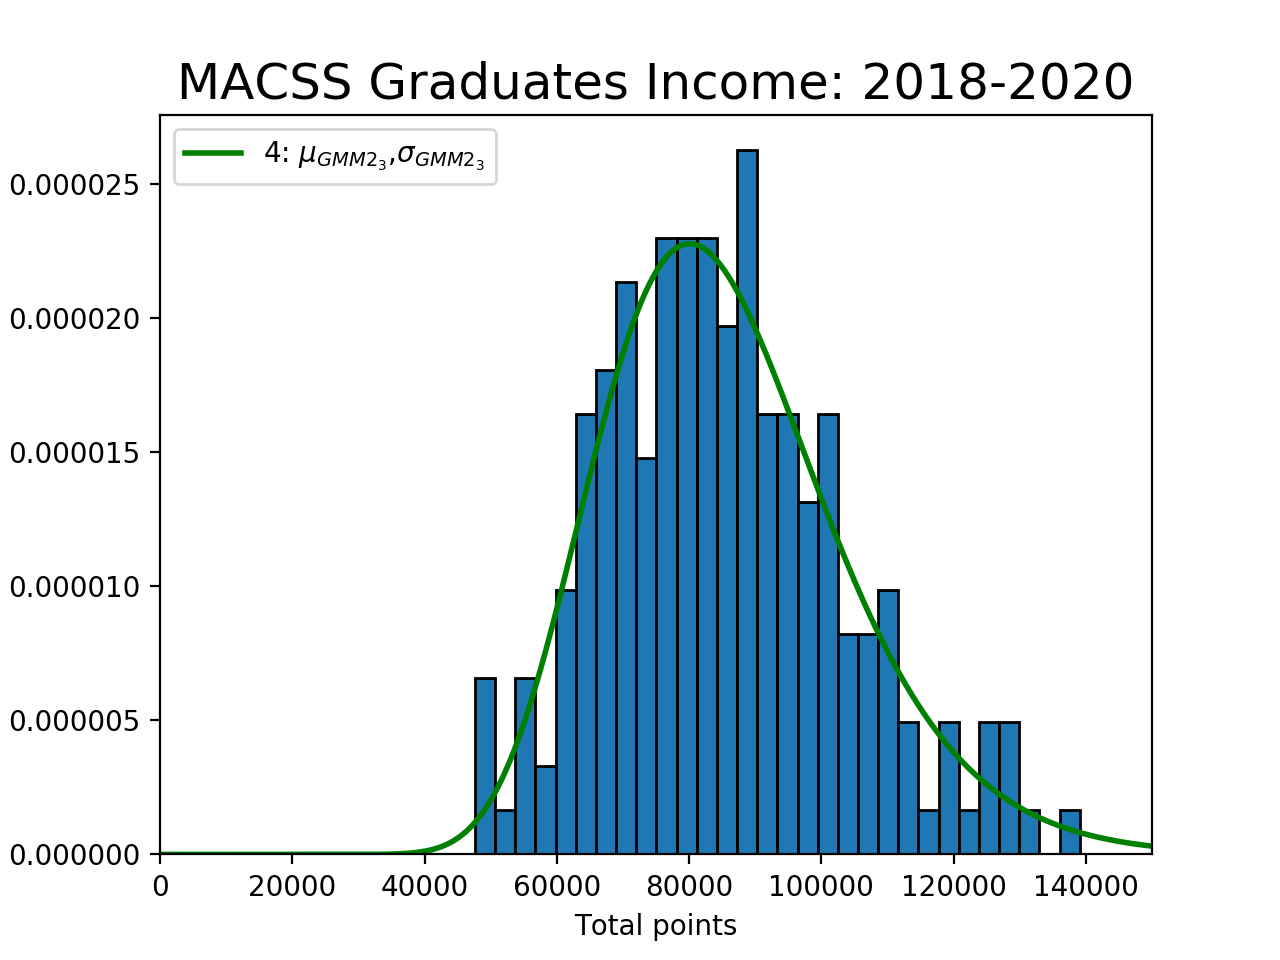

c:\users\pahadrianus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
c:\users\pahadrianus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
c:\users\pahadrianus\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


In [71]:
num_bins = 30
count, bins, ignored = plt.hist(data, num_bins,
                                edgecolor='k', density=True)
plt.title('MACSS Graduates Income: 2018-2020', fontsize=18)
plt.xlabel(r'Total points')
plt.ylabel(r'Percent of income')
plt.xlim([0, 150000]) 

dist_pts = np.linspace(0, 150000, 500)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2_3, sig_GMM2_3, 0.0, 1500000),
         linewidth=2, color='g', label='4: $\mu_{GMM2_3}$,$\sigma_{GMM2_3}$')
plt.legend(loc='upper left')

f)
Using the same criterion function, we can see that the estimation from part d), the one done with three moments and identity weighing matrix generates the smallest error. Therefore we can conclude that this result fits the data the most among all options above.

2.

In [72]:
import pandas as pd

In [73]:
df = pd.read_csv('sick.txt', sep=",", header='infer')
df

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90
...,...,...,...,...
195,0.53,30.56,0.74,41.76
196,0.86,33.97,1.40,39.10
197,1.39,44.00,2.45,40.95
198,0.72,22.30,1.03,23.14


In [74]:
y, x1, x2, x3 = df['sick'], df['age'], df['children'], df['avgtemp_winter']

In [85]:
def criterion(params, *args):
    beta_0, beta_1, beta_2, beta_3 = params
    y, x1, x2, x3, W = args
    
    moms_data = y
    moms_model = beta_0 + beta_1 * x1 + beta_2 * x2 + beta_3 * x3
    
    err = (moms_model - moms_data) / moms_data #not simple

    crit_val = err.T @ W @ err 
    
    return crit_val

In [86]:
W_hat1 = np.eye(len(y))

bnd = ((None, None), (-1, 1), (-1, 1), (-1, 1))
b0_init = 0
b1_init = 0
b2_init = 0
b3_init = 0

params_init = np.array([b0_init, b1_init, b2_init, b3_init])
args_lr = (y, x1, x2, x3, W_hat1)

results = opt.minimize(criterion, params_init, args=(args_lr), method='L-BFGS-B', bounds=bnd)
bhat_0, bhat_1, bhat_2, bhat_3 = results.x
results

      fun: 0.01485678667129471
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00037355,  0.00201134,  0.00157339, -0.01546905])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 125
      nit: 18
   status: 0
  success: True
        x: array([ 0.25222115,  0.0130229 ,  0.39976884, -0.01006018])

In [87]:
print('estimated parameters: ', bhat_0, bhat_1, bhat_2, bhat_3)

estimated parameters:  0.2522211548102769 0.013022895713840573 0.39976884070096397 -0.010060175373698256
